In [2]:
import numpy as np
import cv2
from object_detection.builders import model_builder
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import config_util
from object_detection.utils import label_map_util
import tensorflow as tf
import os

import six
from playsound import playsound
import collections
import math
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
PATH_TO_LABELS = os.path.join("inference_graph/labelmap.pbtxt")
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging

tf.get_logger().setLevel('ERROR')   

Načtení modelu

In [4]:

configs = config_util.get_configs_from_pipeline_file(
    "inference_graph/pipeline.config")
model_config = configs['model']
detection_model = model_builder.build(
    model_config=model_config, is_training=False)

Načtení natrénovanách hodnot do modelu.

In [5]:
# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join('inference_graph/checkpoint/', 'ckpt-0')
             ).expect_partial()

In [6]:

@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])


category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

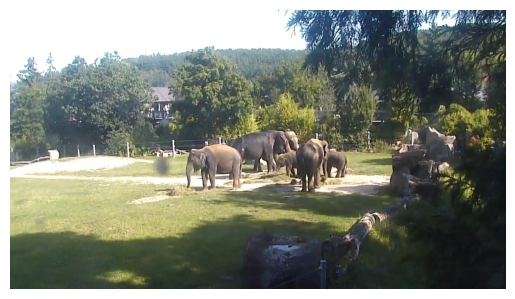

In [7]:
image_np = cv2.imread("captured_frames/frame_0.jpg")
plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### Predikce

In [8]:
# image_np_expanded = np.expand_dims(image_np, axis=0)
input_tensor = tf.convert_to_tensor(
        np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

In [19]:
label_id_offset = 1
image_np_with_detections = image_np.copy()

min_score_thresh = 0.35

box_to_display_str_map = collections.defaultdict(list)
box_to_color_map = collections.defaultdict(str)

number_of_items = 0

for i in range(detections['detection_boxes'][0].numpy().shape[0]):

    if detections['detection_scores'][0].numpy() is None or detections['detection_scores'][0].numpy()[i] > min_score_thresh:

        box = tuple(detections['detection_boxes'][0].numpy()[i].tolist())

        display_str = ''

        if (detections['detection_classes'][0].numpy() + label_id_offset).astype(int)[i] in six.viewkeys(category_index):
            class_name = category_index[(detections['detection_classes'][0].numpy() + label_id_offset).astype(int)[i]]['name']
            display_str = str(class_name)
            display_str = '{}: {}%'.format(display_str, round(
                100*detections['detection_scores'][0].numpy()[i]))

            box_to_display_str_map[box].append(display_str)

            box_to_color_map[box] = "Red"

            if "Elephant" in box_to_display_str_map[box][0]:
                number_of_items = number_of_items + 1


In [20]:
im_width, im_height = image_np.shape[1::-1]

for box, color in box_to_color_map.items():
    ymin, xmin, ymax, xmax = box

    ymin = ymin * im_height
    xmin = xmin * im_width
    ymax = ymax * im_height
    xmax = xmax * im_width

    x = xmin
    y = ymin
    w = xmax - xmin
    h = ymax - ymin

    box_color = (0, 0, 0)

    if color == "Red":
        box_color = (0, 0, 255)

    cv2.rectangle(image_np_with_detections, (int(x), int(y)),
                    (int(x) + int(w), int(y) + int(h)), box_color, 4)
    cv2.putText(image_np_with_detections, 'Elephant', (int(x), int(
        y)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)



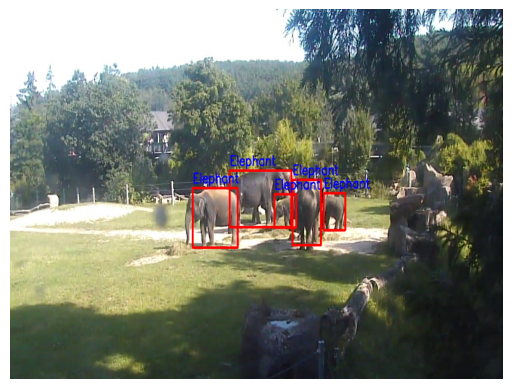

In [21]:
plt.imshow(cv2.cvtColor(cv2.resize(image_np_with_detections, (800, 600)), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [45]:
def predict_elephants(image_path):
    image_np = cv2.imread(image_path)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections, predictions_dict, shapes = detect_fn(input_tensor)
    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    min_score_thresh = 0.40

    box_to_display_str_map = collections.defaultdict(list)
    box_to_color_map = collections.defaultdict(str)

    number_of_items = 0

    for i in range(detections['detection_boxes'][0].numpy().shape[0]):

        if detections['detection_scores'][0].numpy() is None or detections['detection_scores'][0].numpy()[i] > min_score_thresh:

            box = tuple(detections['detection_boxes'][0].numpy()[i].tolist())

            display_str = ''

            if (detections['detection_classes'][0].numpy() + label_id_offset).astype(int)[i] in six.viewkeys(category_index):
                class_name = category_index[(detections['detection_classes'][0].numpy() + label_id_offset).astype(int)[i]]['name']
                display_str = str(class_name)
                display_str = '{}: {}%'.format(display_str, round(
                    100*detections['detection_scores'][0].numpy()[i]))

                box_to_display_str_map[box].append(display_str)

                box_to_color_map[box] = "Red"

                if "Elephant" in box_to_display_str_map[box][0]:
                    number_of_items += 1
    im_width, im_height = image_np.shape[1::-1]

    for box, color in box_to_color_map.items():
        ymin, xmin, ymax, xmax = box

        ymin = ymin * im_height
        xmin = xmin * im_width
        ymax = ymax * im_height
        xmax = xmax * im_width

        x = xmin
        y = ymin
        w = xmax - xmin
        h = ymax - ymin

        box_color = (0, 0, 0)

        if color == "Red":
            box_color = (0, 0, 255)

        cv2.rectangle(image_np_with_detections, (int(x), int(y)),
                        (int(x) + int(w), int(y) + int(h)), box_color, 4)
        cv2.putText(image_np_with_detections, 'Elephant', (int(x), int(
            y)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    return image_np_with_detections, number_of_items



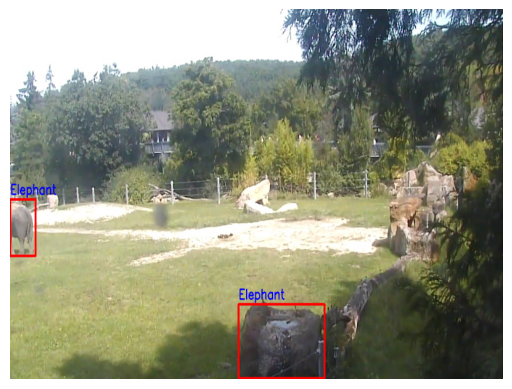

In [57]:
image, count = predict_elephants('captured_frames/frame_11.jpg')
plt.imshow(cv2.cvtColor(cv2.resize(image, (800, 600)), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [47]:
images = []
counts = []
for i in range(17):
    image, count = predict_elephants(f'captured_frames/frame_{i}.jpg')
    images.append(image)
    counts.append(count)
    

In [34]:
real_counts = [6, 5, 3, 5, 6, 1, 1, 1, 1, 0, 0, 1, 0, 0, 2, 4, 3]

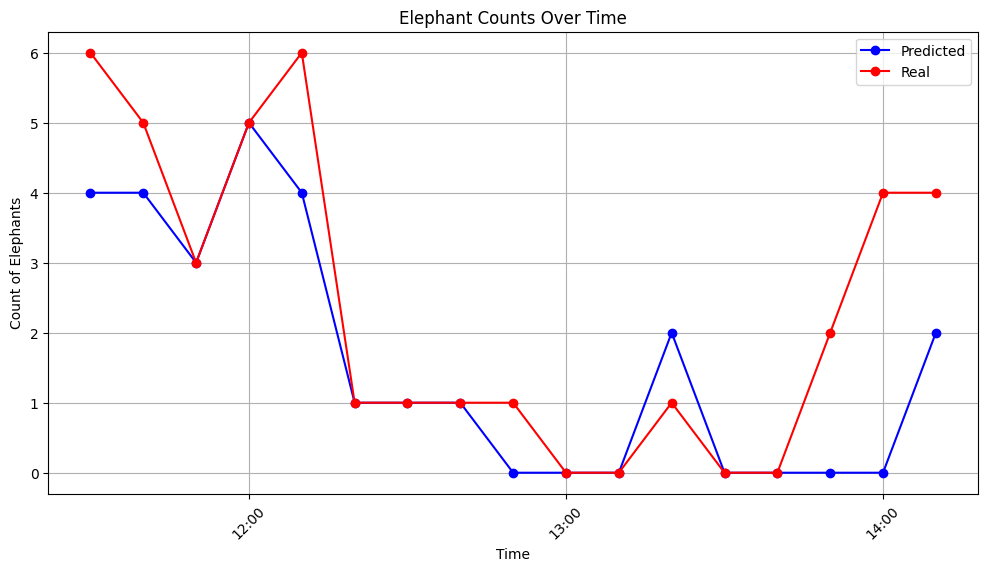

In [48]:
import pandas as pd
import matplotlib.dates as mdates

# Starting time
start_time = pd.Timestamp('11:30')

# Generating timestamps at 15 minute intervals
timestamps = pd.date_range(start=start_time, periods=len(counts), freq='10T')

# Creating the line graph with timestamps
plt.figure(figsize=(12, 6))
plt.plot(timestamps, counts, marker='o', linestyle='-', color='b')
plt.plot(timestamps, real_counts, marker='o', linestyle='-', color='r')
plt.title('Elephant Counts Over Time')
plt.xlabel('Time')
plt.ylabel('Count of Elephants')
plt.grid(True)

# Formatting the x-axis to show the time more clearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.xticks(rotation=45)
plt.legend(['Predicted', 'Real'])

plt.show()